In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl
import time
#import torch

In [171]:
# Parameters
entropy_reg = 0.1


In [156]:
# Utils

def vect_norm(x):
    return np.sqrt(x.T@x)

def graph_viz(G,mu):
    pos = nx.spring_layout(G,seed=1)
    N = len(mu) 
    nx.draw_networkx(G, pos = pos, node_color=mu, cmap = 'Greys', vmin = 0, vmax = 1, with_labels = False)
    plt.tight_layout()
    plt.axis("off")
    plt.show()
    
    

In [172]:
def kernel(G, entropy_reg = entropy_reg, deg = 2):
    n = len(G.nodes)
    dist = np.zeros((n,n))
    for (i,source_node) in enumerate(G.nodes):
        for (j,target_node) in enumerate(G.nodes):
            dist[i,j] = nx.shortest_path_length(G,source = source_node, target = target_node)
    if deg == 1:
        return np.exp(-dist/entropy_reg), dist
    else:
        return np.exp(-dist**2/entropy_reg), dist**2
            


In [183]:
def convolutional_wasserstein(mu_0, mu_1, a,  entropy_reg = entropy_reg, Kernel = f_kernel, n_iter = 2000, wass_order = 2):
    N = len(mu_0)
    w = np.ones(N)
    Err_mu_0 = []
    Err_mu_1 = []
    
   
    
    for i in range(n_iter):
        
        # sinkhorn step 1
        v = mu_0/ Kernel(a*w)  
         
        # error computation
        Err_mu_1.append(vect_norm(w * (Kernel(a*v)) - mu_1)/vect_norm(mu_1))
        
        # sinkhorn step 2
        w = mu_1 / Kernel(a*v)
        Err_mu_0.append(vect_norm(v * (Kernel(a*w)) - mu_0)/vect_norm(mu_0))

    wass = entropy_reg * a.T @ (mu_0*np.log(np.maximum(1e-19*np.ones(N),v)) + mu_1*np.log(np.maximum(1e-19*np.ones(N),w)) )
    if wass_order == 1:     
        return wass, Err_mu_0, Err_mu_1
    else:
        return np.sqrt(wass), Err_mu_0, Err_mu_1


In [159]:
def wasserstein_barycenter(mu, a,  entropy_reg = entropy_reg, Kernel = f_kernel, n_iter = 2000, lambd = None):
    
    R = mu.shape[1]
    N = mu.shape[0]
    
    if lambd == None:
        lambd = np.ones(R)/R
    w = np.ones((N,R))
    v = np.copy(w)
    error = np.zeros(n_iter)
    

    for i in range(n_iter):
        
        # First step of the Bergman projection (onto C1)
        target_mu = np.log(np.ones(N))
        for k in range(R):
            # To monitor $\sum_k \norm{PI_k * a - mu_k} $
            error[i] += vect_norm(w[:,k] * Kernel(a*v[:,k]) - mu[:,k])/vect_norm(mu[:,k])
            w[:,k] = mu[:,k]/Kernel(a*v[:,k]) 
        
        
            target_mu +=  lambd[k] * np.log(np.maximum(1e-19*np.ones(len(w[:,k])), v[:,k]*Kernel(a*w[:,k])))
        target_mu = np.exp(target_mu)


        #target_mu = entropic_sharpening(target_mu,H,a)
        
        
        # Second projection (onto C2)
        for k in range(R):
            v[:,k] =  target_mu / Kernel(a*w[:,k])
            
    return target_mu, error
    

## Tests

In [195]:
# Arguments
N = 20
R = 4
G = nx.full_rary_tree(4,N)
#mu = [np.random.dirichlet(np.random.rand(N)*5+1) for k in range(R)]

# Clustered distrib
# mu = [[0]*N for R in range(R)]
# for k in range(R):
#     nodes = np.random.randint(1+k*5,10+k*5,size=4)
#     for j in range(4):
#         mu[k][nodes[j]] = 1/4
mu = [[0,1/5,0,0,0,1/5,1/5,1/5,1/5,0,0,0,0,0,0,0,0,0,0,0],[0,0,1/5,0,0,0,0,0,0,1/5,1/5,1/5,1/5,0,0,0,0,0,0,0],
      [1/5,0,1/5,1/5,1/5,0,0,0,0,1/5,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/5,1/5,1/5,1/5,1/5,0]]
        
a = np.ones(N)

In [196]:
#%time 
K, dist = kernel(G, entropy_reg = entropy_reg, deg = 2)
f_kernel = lambda x: np.dot(K,x)

In [197]:

wass, Err_mu_0, Err_mu_1 = convolutional_wasserstein(np.array(mu[0]), np.array(mu[1]), a)


/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_8342/3805022757.py:2: RuntimeWarning: divide by zero encountered in log
  ax[0].plot(np.log(Err_mu_0))


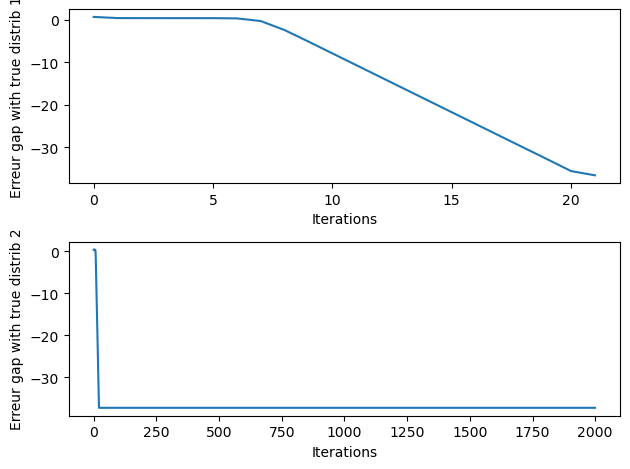

In [198]:

fig, ax = plt.subplots(2)
ax[0].plot(np.log(Err_mu_0))
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Erreur gap with true distrib 1")

ax[1].plot(np.log(Err_mu_1))
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Erreur gap with true distrib 2")
plt.tight_layout()
plt.show()

In [199]:
barycenter_mu, error = wasserstein_barycenter(np.array(mu).T, a)

Distribution:  0


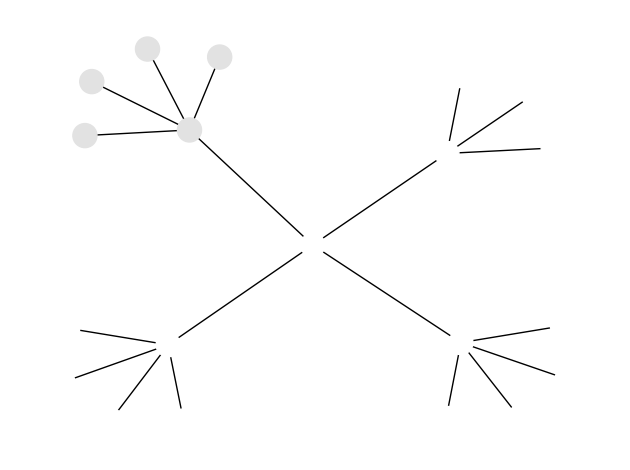

Distribution:  1


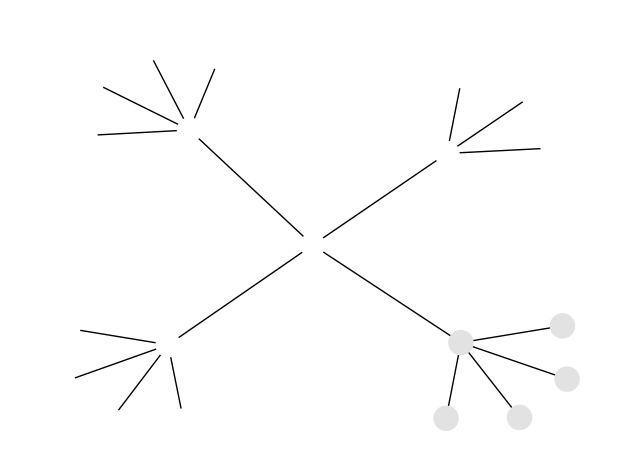

Distribution:  2


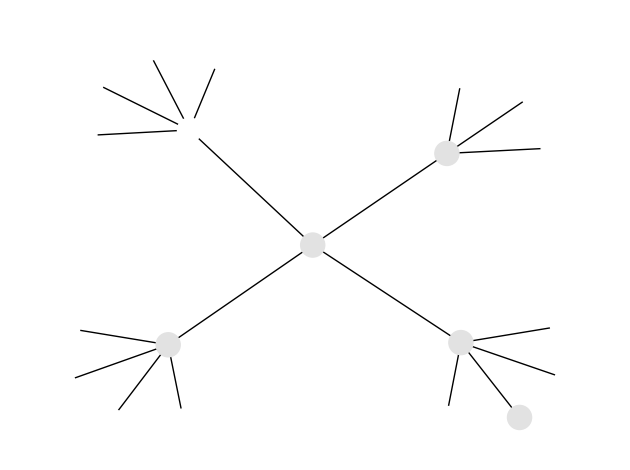

Distribution:  3


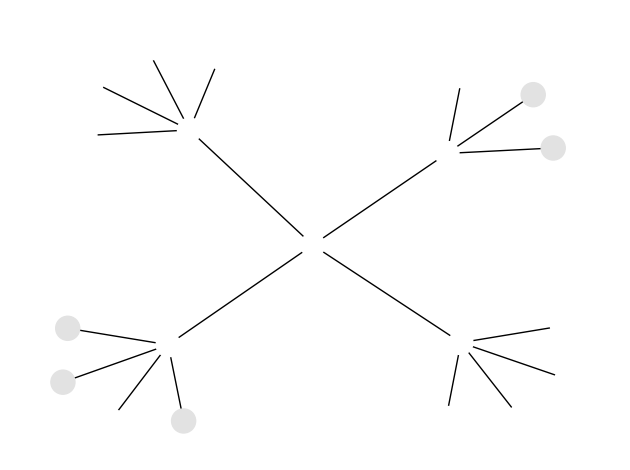

Distribution Barycentre


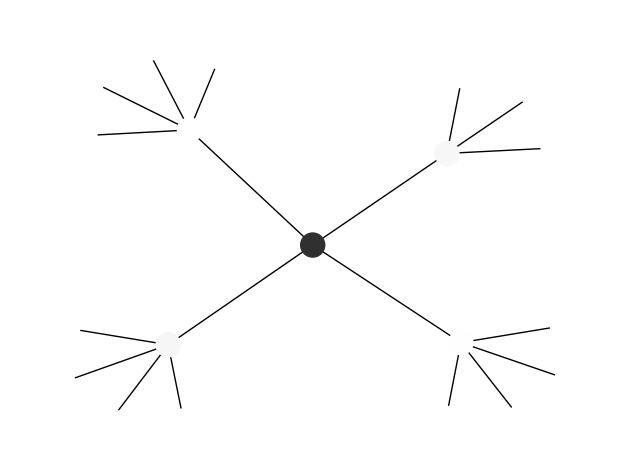

In [200]:
for (compt,mu_) in enumerate(mu):
    print("Distribution: ",compt)
    graph_viz(G,mu_)
    
print("Distribution Barycentre")
graph_viz(G,barycenter_mu)
    

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_8342/2892036798.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(error))


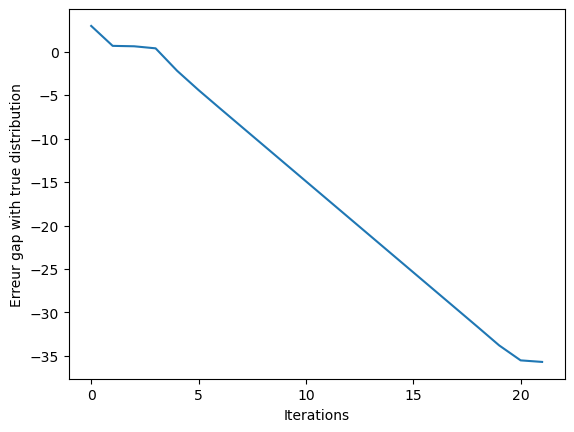

In [194]:
plt.figure()
plt.plot(np.log(error))
plt.xlabel("Iterations")
plt.ylabel("Erreur gap with true distribution")
plt.show()

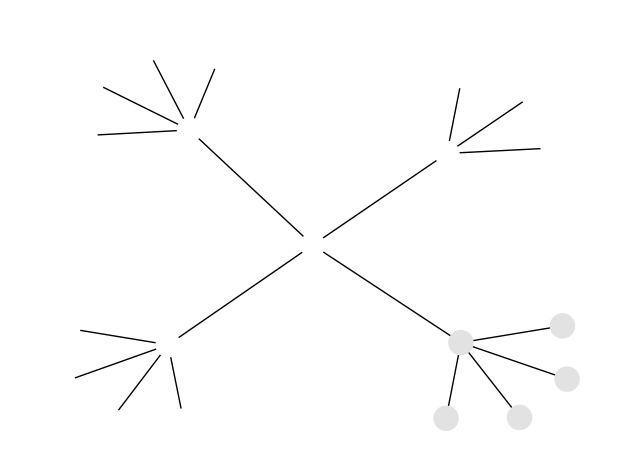

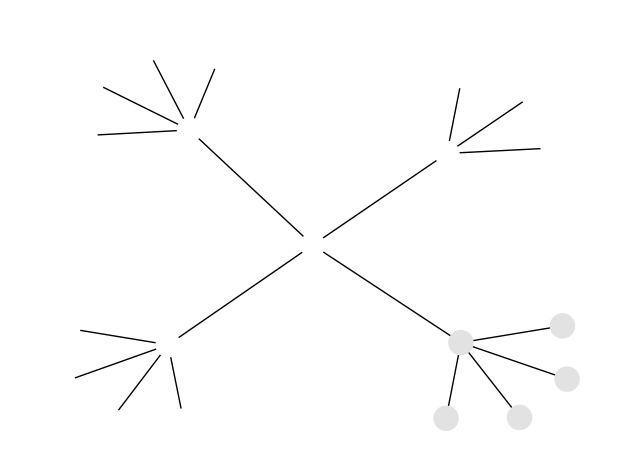

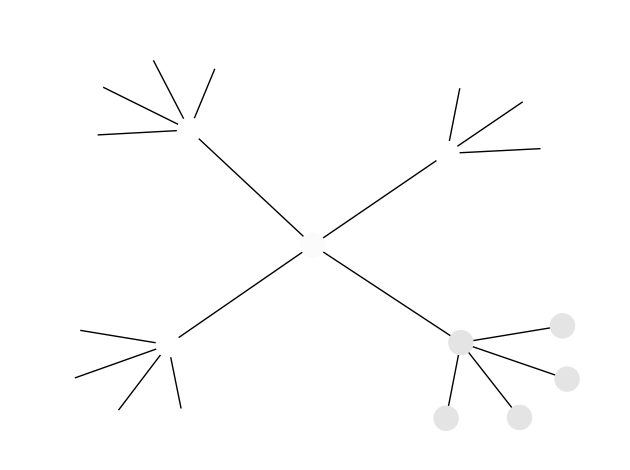

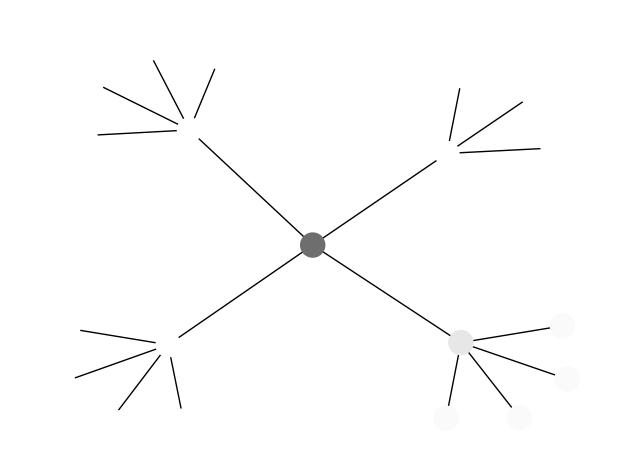

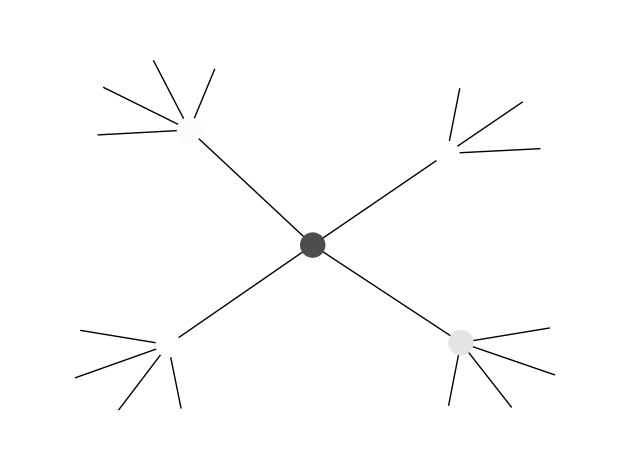

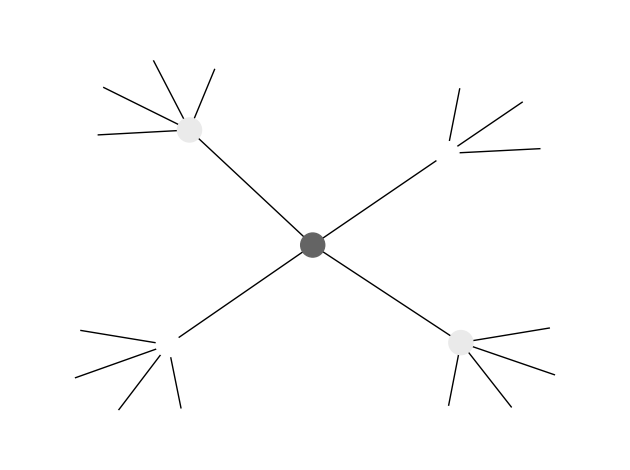

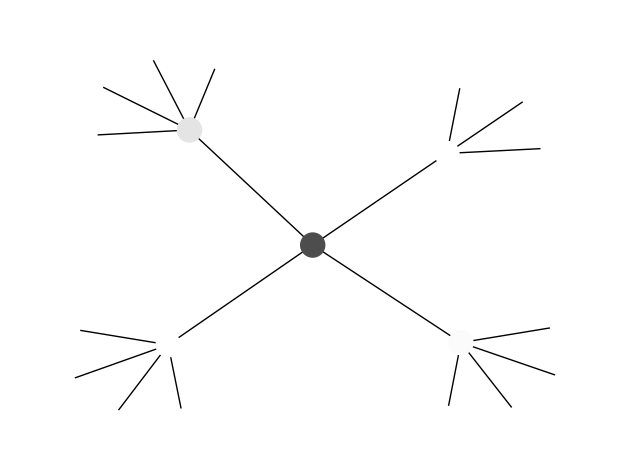

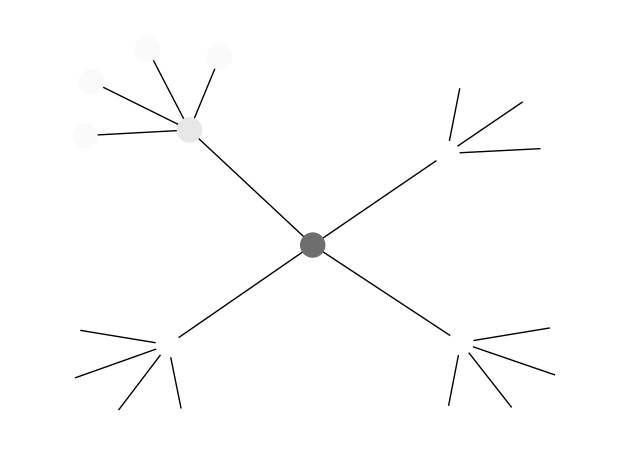

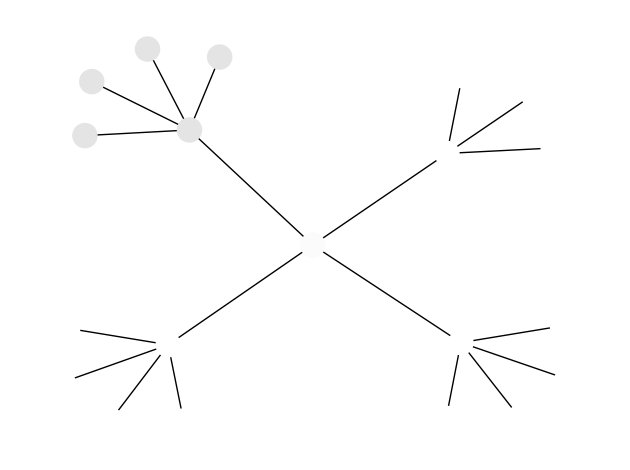

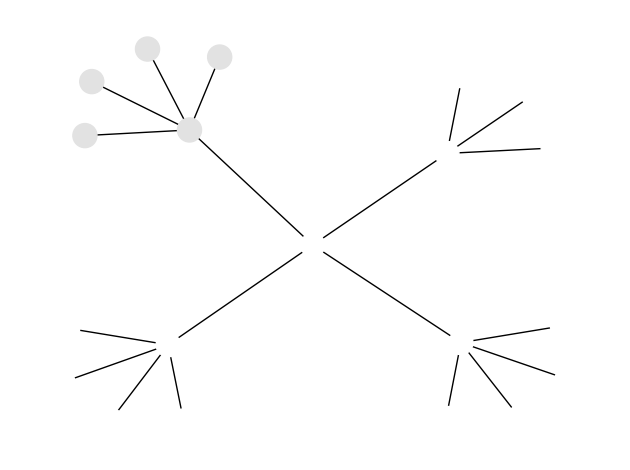

In [190]:
for t in range(0,10):
    barycenter_mu, error = wasserstein_barycenter(np.array(mu).T, a,lambd = [t/10,1-t/10])
    graph_viz(G,barycenter_mu)

### Images

In [218]:
def reconstruct_image(N,vect):
    image = np.zeros((N,N))
    for i in range(N):
        image[i,:]= vect[i*N:(i+1)*N]
    return image

/var/folders/j2/99bn3bfd5fq_xmh377nj_mw80000gn/T/ipykernel_8342/2913034613.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  a = imageio.imread("../nt_toolbox/data/" + names[i] + ".bmp") # ,N)


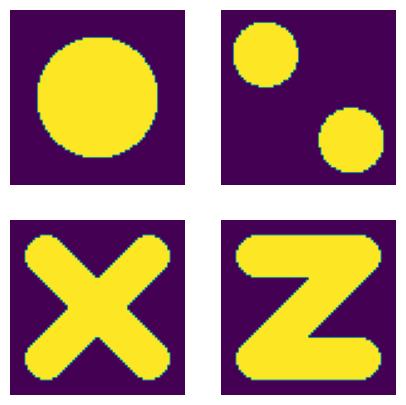

In [219]:
import imageio

normalize = lambda p: p/np.sum(p)
rescale = lambda x: (x-x.min())/(x.max()-x.min())
N = 70
names = ['disk','twodisks','letter-x','letter-z']
vmin = .01
A = np.zeros((N*N,len(names)))
for i in range(len(names)):
    a = imageio.imread("../nt_toolbox/data/" + names[i] + ".bmp") # ,N) 
    a = normalize(rescale(a)+vmin)
    A[:,i] = a.flatten()
R = len(names)
plt.figure(figsize=(5,5))

for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(reconstruct_image(N,A[:,i]))
    plt.axis('off')

In [229]:
entropy_reg = 0.01
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/entropy_reg)
K = lambda x: np.dot(np.dot(K1,reconstruct_image(N,x)),K1).flatten()
a = np.ones(N*N)

target_mu, error = wasserstein_barycenter(A[:,1:3], a,  entropy_reg = entropy_reg, Kernel = K)



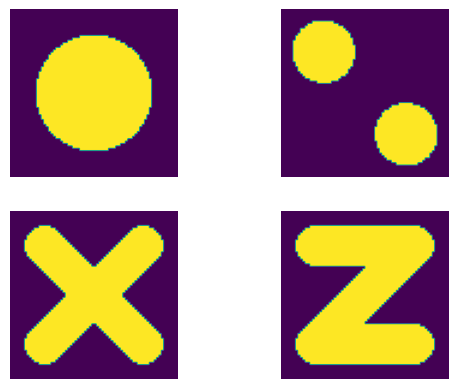

In [227]:
for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(reconstruct_image(N,A[:,i]))
    plt.axis('off')

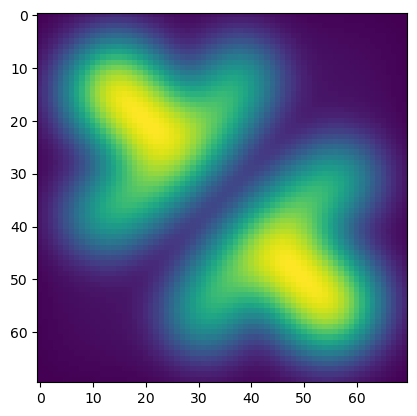

In [230]:
plt.imshow(reconstruct_image(N,target_mu))